# Flower Classification using Convolutional Neural Network

Taha Zanzibarwala
 
7th September, 2020

### Introduction

Image Classification is one of the core problem statement being solved with Deep Learning methods. By definition, image classification is to extract patterns or information from multiple groups of images. The resulting features are used to decide the group/class of a new input image. Convolutional Neural Networks (CNN) have been the go-to for image classification, among many other functionalities for it's effciency and effectiveness. To see how CNNs work, visit [here](https://analyticsindiamag.com/convolutional-neural-network-image-classification-overview/). 

### Flower Classification Problem
We will be using the Kaggle [dataset](https://www.kaggle.com/ayaanmustafa/flower) which consists images of 3 classes of flowers, namely, Lotus, Rose and Sunflower. The dataset consists of images being distributed in training and validation folders. The images are stored in folders named as their classes. 

### Approach
We will implement a 3-layer convolutional network using the Keras framework. We will take advantage of the [ImageDataGenerator](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) class in Keras, given the folder structure of the dataset. The class will allow on-the-go data augmentation and can be used as a data pipeline for the CNN model directly.  

Importing necessary libraries

In [22]:
import os
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.preprocessing import image

K.set_image_data_format('channels_first') # Setting channels first at keras backend

Iterating over the training folder to check the number of samples in each class.

In [3]:
train_data_path = "/archive/flower_images/training"
for folder in os.listdir(train_data_path):
  path = train_data_path + "//" + folder
  print(folder + " " +  str(len(os.listdir(path))))

lotus 71
rose 75
sunflower 126


As we see above, the training data has lower number of samples contrary to what might give a satisfactory result with CNNs. That is where data augmentation will come handy. The ImageDataGenerator class will do the heavy lifting here. 

[ImageDataGenerator](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) accepts parameters such:

- rotation_range: value between 0-180. A range from 0 to value passed to which the image is randomly roatated.
- width_shift_range: Translates image horizontally. Value is fraction of total width.
- height_shift_range: Translates image vertically. Value is fraction of total height.
- shear_range: Random [shear transformations](https://en.wikipedia.org/wiki/Shear_mapping).
- zoom_range: Randomly zooms images.
- rescale: Rescaling factor

See the documentation for more options to the class.

In [4]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.2,
    rescale=1./255,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)


We define a CNN model with 3 layers of convloutions paired with max pooling. The convolutions are followed by a fully-connected layer and the output layer. The input size is defined (3, 150, 150). 

We are using categorical crossentropy as loss function. And RMSProp as optimizer.

In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(3, 150, 150)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', data_format='channels_first'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', data_format='channels_first'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', data_format='channels_first'))
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 148, 148)      896       
_________________________________________________________________
activation (Activation)      (None, 32, 148, 148)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 74, 74)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 72, 72)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 72, 72)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 36, 36)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 34, 34)        1

In [6]:
batch_size = 25

We take advantage of [flow_from_directory](https://keras.io/api/preprocessing/image/#flowfromdirectory-method) method to generate a data piepline directly for the CNN model. We use the class mode as categorical as we used categorical crossentropy as the loss function. The train and validation generator can be passed directly to the training function, thus letting Keras do the heavy lifting.

In [7]:
train_generator = train_datagen.flow_from_directory(
        '/archive/flower_images/training', 
        target_size=(150, 150),  
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        '/archive/flower_images/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 271 images belonging to 3 classes.
Found 59 images belonging to 3 classes.


In [8]:
steps_train = train_generator.n // batch_size
steps_valid = validation_generator.n // batch_size

We will be saving the model only if it improves loss on the validation dataset. The ModelCheckpoint is one of the many callbacks in Keras to interrupt training and saving the weights. See [documentation](https://keras.io/api/callbacks/).

In [9]:
checkpoint =  tf.keras.callbacks.ModelCheckpoint('/best_model.hdf5', save_best_only = True, monitor = 'val_loss', verbose = 1)

The model.fit_generator method is used to train the model on the dataset. The fit_generator method accepts the generator object (as implemented above). 

Note: model.fit method also accepts generator object and is normally implemented. See [documentation](https://keras.io/api/models/model_training_apis/#fit-method).

In [10]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=steps_valid,
        callbacks=[checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.1078 - accuracy: 0.4634
Epoch 00001: val_loss improved from inf to 1.18535, saving model to /content/best_model.hdf5
10/10 [==============================] - 107s 11s/step - loss: 1.1078 - accuracy: 0.4634 - val_loss: 1.1854 - val_accuracy: 0.1400
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.8506 - accuracy: 0.5854
Epoch 00002: val_loss improved from 1.18535 to 0.70961, saving model to /content/best_model.hdf5
10/10 [==============================] - 7s 695ms/step - loss: 0.8506 - accuracy: 0.5854 - val_loss: 0.7096 - val_accuracy: 0.7200
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.5792 - accuracy: 0.8008
Epoch 00003: val_loss did not improve from 0.70961
10/10 [==============================] - 7s 728ms/step - loss: 0.5792 - accuracy: 0.8008 - val_loss: 0.7544 - val_accuracy: 0.6200
Epoch 4/

The highest validation accuracy obtained is 0.98. The result is satisfactory given the amount of data we were provided. 

Visualizing the loss and accuracy graph, we will get more idea on how our model performed.

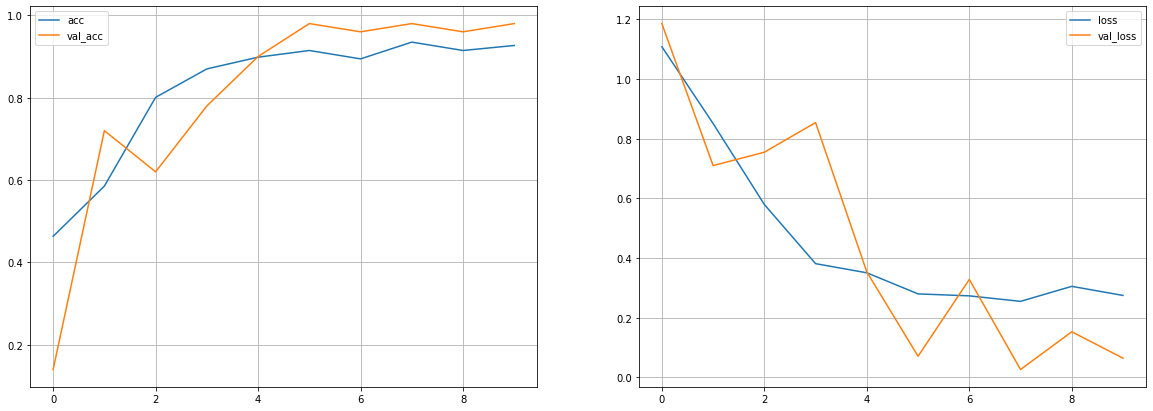

In [11]:
H = history.history
fig = plt.figure(figsize = (20, 7))
plt.subplot(121)
plt.plot(H['accuracy'], label = 'acc')
plt.plot(H['val_accuracy'], label = 'val_acc')
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(H['loss'], label = 'loss')
plt.plot(H['val_loss'], label = 'val_loss')
plt.grid()
plt.legend()

We can test our model on randomly picked images now. I have downloaded one image from each class from [Pixabay](https://pixabay.com/). We resize the image using Keras preprocessing module to our input size, i.e. (150, 150). The images are stored in /images folder.

In [13]:
model.load_weights('/best_model.hdf5')

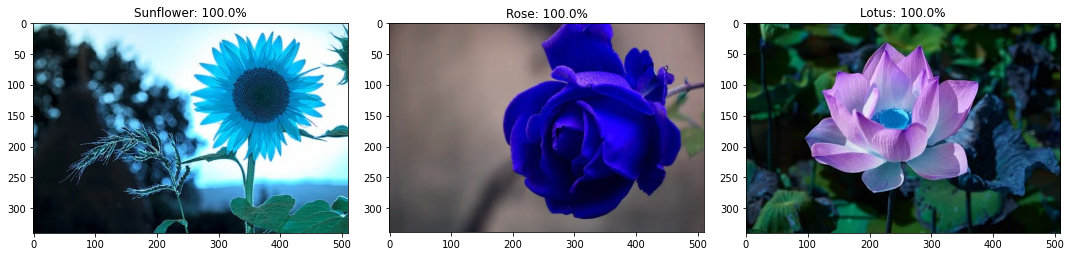

In [33]:
class_list = ["Lotus", "Rose", "Sunflower"]

fig = plt.figure(figsize = (15, 15))
for temp, img in enumerate(os.listdir('/images')):
  plt.subplot(f'33{temp+1}')
  temp += 1

  img_path = '/images' + '//' + img

  i_cv = cv2.imread(img_path, 1)

  img_width, img_height = 150, 150
  i = image.load_img(img_path, target_size = (img_width, img_height))
  i = image.img_to_array(i)
  i = np.expand_dims(i, axis = 0)

  preds = model.predict(i)
  preds = zip(class_list, list(preds[0]))
  preds = sorted(list(preds), key = lambda z: z[1], reverse = True)[:1]
  plt.imshow(i_cv)
  plt.title(f'{preds[0][0]}: {round(preds[0][1] * 100, 2)}%') 

plt.tight_layout()  

Our model predicts the correct class for all three images, concluding that our CNN model is working perfectly. We could use many other publicly available datasets, having a much varied and larger samples to develop an intricate model. 

Constructive feedback is always welcome.